# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [953]:
# import libraries
import sys
import sklearn
import nltk
import numpy as np
import pandas as pd
from pprint import pprint
from sqlalchemy import create_engine

In [954]:
def load_data(
    x_column_name = "message", 
    y_start=4, 
    y_stop=None, 
    table_name='cleandata',
    database_path="DisasterTweets.db"
    ):
    """
    Fetch cleaned data from an sqlite database and return as 
    pandas data frame.

    Args:
       x_column_name (str): Name of the column in the dataset table
                             for input features (default is 'message').
        y_start (int): The starting index for the target columns (default is 4).
        y_stop (int or None): The stopping index for the target columns.
                              If None, all columns from y_start onward will be 
                              selected (default is None).
        table_name (str): Name of the table in the database containing the dataset
                          (default is 'cleandata').
        database_path (str): Relative path to the database file containing the 
                             cleaned dataset (default is 'DisasterTweets.db').
    
    Returns:
        X (numpy.ndarray): Input feature data.
        y (numpy.ndarray): Target output data.
        df (pandas.DataFrame): DataFrame containing both input features and target outputs.
    """
    conn_engine = create_engine("sqlite:///"+database_path)
    # Load data from a specific table into a DataFrame
    df = pd.read_sql_table(table_name, con=conn_engine)
    # Extract the input feature column
    X = df[x_column_name]
    # Extract the target columns
    if y_stop == None:
        y = df.iloc[:,y_start:]
    else:
        y = df.iloc[:, y_start:y_stop] 
    classes = list(y.columns)
    return X.values, y.values, classes

In [955]:
def audit_data(x_train, y_train, class_names, x_test=None, y_test=None):
    """
    Performs a comprehensive audit of machine learning dataset properties and types.
    
    Parameters:
    -----------
    x_train(numpy.ndarray): Training features
    y_train(numpy.ndarray): Training labels
    class_names (list): list of all class names in the output dataset.
    x_test(numpy.ndarray): Test features -- optional
    y_test(numpy.ndarray): Test labels -- optional
        
    Returns:
    --------
    dict
        Dictionary containing all the audit information
    """
    print("-"*100)
    print("Dataset Audit Report")
    
    # View the first few rows of the DataFrame
    x_df = pd.DataFrame(x_train)
    y_df = pd.DataFrame(y_train)
    x_df.columns =["input_features"]
    y_df.columns = list(class_names)
    display(x_df.head(3))
    display(y_df.head(3))

    audit_info = {}
    
    # Data shapes
    audit_info['train_shapes'] = {
        'X_train': x_train.shape,
        'y_train': y_train.shape
    }
    
    if X_test is not None and y_test is not None:
        audit_info['test_shapes'] = {
            'X_test': x_test.shape,
            'y_test': y_test.shape
        }
    
    # Data types
    audit_info['data_types'] = {
        'X_train_type': type(x_train),
        'y_train_type': type(y_train)
    }
    
    # Target variable properties
    audit_info['target_info'] = {
        'unique_values': np.unique(np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train)
    }
    
    # Display results
    print("-"*100)
    print("\nShapes:")
    print(f"Training set, X: {x_train.shape}")
    print(f"Training set, y: {y_train.shape}")
    if x_test is not None:
        print(f"Test set, X: {x_test.shape}")
    if y_test is not None:
        print(f"Test set, y: {y_test.shape}")
        
    print("-"*100)
    print("\nData Types:")
    print(f"X_train type: {type(x_train)}")
    print(f"y_train type: {type(y_train)}")
    
    print("-"*100)
    print("\nTarget Information:")
    print(f"Unique y values: {audit_info['target_info']['unique_values']}\n")
    
     # Convert one-hot to labels
    y_train_labels = np.argmax(y_train, axis=1)
    
    # Get distribution of class samples, to evaluate dataset balance.
    # unique, counts = np.unique(y_train_labels, return_counts=True)
    # samples_distr = pd.DataFrame(
    #     {"categories":[classes[index] for index in unique],
    #      "no. of samples":counts
    # })
    # samples_distr.set_index(unique,inplace=True)
    
    class_df = pd.DataFrame({"labels": classes})

    # Count occurrences of each class label
    counts = np.bincount(y_train_labels, minlength=len(classes))

    # Create a DataFrame with counts
    # Add the category/class names as a column

    samples_distr = pd.DataFrame({
        "categories": classes,
        "no. of samples": counts    
    })
    
    if 'ipykernel' in sys.modules:
        # Running in a Jupyter Notebook.
        print("-"*100)
        print("\nClass Distribution in Training Set:")
        display(samples_distr)
        # Get class names from the dataset
        print("-"*100)
        display(class_df)
    else:
        # Not running in a Jupyter Notebook.
        print("-"*100)
        print("\nClass Distribution in Training Set:")
        print(samples_distr)
        print("-"*100)
        # Get class names from the dataset
        print(class_df)    
    
    print("\n")
            
    return audit_info        

In [956]:
# load data from database
db_path = 'DisasterTweets.db'
X, y, classes = load_data(
                        x_column_name="message",
                        y_start=5,
                        table_name="cleandata",
                        database_path=db_path
                    )

In [957]:
# Inspect the training dataset
print(audit_data(X, y, classes))

----------------------------------------------------------------------------------------------------
Dataset Audit Report


,input_features
0,Weather update - a cold front from Cuba that c...
1,Is the Hurricane over or is it not over
2,Looking for someone but no name


,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


----------------------------------------------------------------------------------------------------

Shapes:
Training set, X: (26386,)
Training set, y: (26386, 35)
----------------------------------------------------------------------------------------------------

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------

Target Information:
Unique y values: [ 0  1  2 18 19 20 21 22 27 34]

----------------------------------------------------------------------------------------------------

Class Distribution in Training Set:


,categories,no. of samples
0,request,15998
1,offer,121
2,aid_related,6778
3,medical_help,0
4,medical_products,0
5,search_and_rescue,0
6,security,0
7,military,0
8,child_alone,0
9,water,0


----------------------------------------------------------------------------------------------------


,labels
0,request
1,offer
2,aid_related
3,medical_help
4,medical_products
5,search_and_rescue
6,security
7,military
8,child_alone
9,water




{'train_shapes': {'X_train': (26386,), 'y_train': (26386, 35)}, 'data_types': {'X_train_type': <class 'numpy.ndarray'>, 'y_train_type': <class 'numpy.ndarray'>}, 'target_info': {'unique_values': array([ 0,  1,  2, 18, 19, 20, 21, 22, 27, 34])}}


### 2. Write a tokenization function to process your text data

In [958]:
# Download the stopwords and all nltk relevant packages.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/emmanuele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [959]:
import re
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


In [960]:
def tokenize(text, stop_words=None):
    """
    Tokenize a text by normalizing, lemmatizing and removing stop words.
    
    Args:
        text (list): list of strings
        stop_words (set): a set of word strings for stop words -- optional.

    Returns:
        tokens(list): list of token strings.
    """
    # Import stopwords if not imported.
    if stop_words is None:
        stop_words = set(stopwords.words("english"))
    
    lemmatizer = WordNetLemmatizer()    
    
    url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Replace URLs with a placeholder and normalize case.
    normalized_text = re.sub(url_regex, ' ', text.lower())

    # Replace non-alphanumeric characters with spaces.
    normalized_text = re.sub(r'[^a-zA-Z0-9]', ' ', normalized_text)
    
    tokens = word_tokenize(normalized_text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [961]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

#help(sklearn.multioutput)

In [962]:
model = Pipeline([
    ("vectorize", CountVectorizer(tokenizer=tokenize)),
    ("tfidf", TfidfTransformer()),
    ("clf", RandomForestClassifier())
])

In [963]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

print(audit_data(X_train, y_train, classes, X_test, y_test))

----------------------------------------------------------------------------------------------------
Dataset Audit Report


,input_features
0,The relief effort to Afghanistan's earthquake ...
1,@trinamariexox I hope Sandy blows open the win...
2,has sanctioned an amount Rs.50.00 crore to dis...


,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,1,1,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


----------------------------------------------------------------------------------------------------

Shapes:
Training set, X: (21108,)
Training set, y: (21108, 35)
Test set, X: (5278,)
Test set, y: (5278, 35)
----------------------------------------------------------------------------------------------------

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------

Target Information:
Unique y values: [ 0  1  2 18 19 20 21 22 27 34]

----------------------------------------------------------------------------------------------------

Class Distribution in Training Set:


,categories,no. of samples
0,request,12821
1,offer,101
2,aid_related,5417
3,medical_help,0
4,medical_products,0
5,search_and_rescue,0
6,security,0
7,military,0
8,child_alone,0
9,water,0


----------------------------------------------------------------------------------------------------


,labels
0,request
1,offer
2,aid_related
3,medical_help
4,medical_products
5,search_and_rescue
6,security
7,military
8,child_alone
9,water




{'train_shapes': {'X_train': (21108,), 'y_train': (21108, 35)}, 'test_shapes': {'X_test': (5278,), 'y_test': (5278, 35)}, 'data_types': {'X_train_type': <class 'numpy.ndarray'>, 'y_train_type': <class 'numpy.ndarray'>}, 'target_info': {'unique_values': array([ 0,  1,  2, 18, 19, 20, 21, 22, 27, 34])}}


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [964]:
trained_model = model.fit(X_train, y_train)

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [965]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#help(sklearn.metrics)

In [966]:
def confusion_matrix_plot(y_test, y_pred, class_names):
    """
    Plots a confusion matrix of the actual class (output) and predicted class.

    Args:
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
    """
    # Convert one-hot to labels
    y_test_labels = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Create confusion matrix with explicit labels
    all_classes = np.arange(len(class_names))  # 0 to 35
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels) #, labels=all_classes)

    # Visualize
    plt.figure(figsize=(13, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()


def calculate_multiclass_accuracy(y_true, y_pred):
    """
    Calculate accuracy for multi-class classification
    
    Args:
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
    
    Returns:
        summary_accuracy_score (float): summary accuracy using decoded labels.
    """
    # Convert to labels if one-hot encoded
    if (len(y_true.shape) > 1) & (len(y_pred.shape) > 1):
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        summary_accuracy_score = accuracy_score(y_true, y_pred)
       
    else:
        print("Empty values for y test or y pred")
        summary_accuracy_score = np.nan
    
    return summary_accuracy_score


def per_class_accuracy(y_true, y_pred, class_names):
    """
    Calculate accuracy for each class separately

    Args
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
    
    return
        accuracies_df (pandas.core.frame.DataFrame): a dataframe of class names 
        and their correspoinding accuracy score for binary classification
    
    """
    accuracies = []
    for i in range(len(class_names)):
        class_data_true = y_true[:, i]
        class_data_pred = y_pred[:, i]
        if (class_data_true.shape[0] > 0) & (class_data_pred.shape[0] > 0):
            class_acc = accuracy_score(class_data_true, class_data_pred)
            accuracies.append(class_acc)
            
        else:
            print("Empty values for y test or y pred")
            class_acc = np.nan
            accuracies.append(class_acc)
            
    
    accuracies_df = pd.DataFrame({"category":class_names, "accuracy":accuracies})
    return accuracies_df
    

def evaluate_multilabel_model(y_true, y_pred, class_names):
    """
    Comprehensive evaluation of a multi-label classification model.
    
    Args:
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
        
    return
        metrics_df(pandas.core.frame.DataFrame): a dataframe of class names 
                              and their correspoinding precision, recall and 
                              F1-score values, for binary classification
    """
    sample_accuracy = calculate_multiclass_accuracy(y_true, y_pred)
    print(f"Overall Sample-wise Accuracy: {sample_accuracy:.3f}\n")
    print("-"*100)

    
    # Calculate per-class accuracy
    print(per_class_accuracy(y_true, y_pred, class_names))
    print("-"*100)

    # *** Per-class classification metrics
    print('Detailed classification report per class')
    print("-"*100)

    
    results = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) > 0:  # Check if there are true instances
            precision = precision_score(y_true[:, i], y_pred[:, i], average='macro', zero_division=0)
            recall = recall_score(y_true[:, i], y_pred[:, i],average='macro', zero_division=0)
            f1 = f1_score(y_true[:, i], y_pred[:, i],average='macro', zero_division=0)
        
            results.append({
                'Class': class_names[i],
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
        
            print(f"\nDetailed metrics for {class_names[i]}:")
            print(classification_report(y_true[:, i], y_pred[:, i], zero_division=0))
        else:
            results.append({
                'Class': class_names[i],
                'Precision': np.nan,
                'Recall': np.nan,
                'F1-Score': np.nan
            })
            print(f"\nNo true instances for {class_names[i]}, skipping detailed report.")
            
    # Create a DataFrame with all classification metrics per class
    print("-"*100)
    metrics_df = pd.DataFrame(results)
    print("\nSummary of all metrics:")
    print("-"*100)
    print(metrics_df.round(3))
    
    # Visualize metrics
    plt.figure(figsize=(10, 6))
    metrics_melted = pd.melt(metrics_df, id_vars=['Class'], 
                           value_vars=['Precision', 'Recall', 'F1-Score'])
    sns.barplot(x='Class', y='value', hue='variable', data=metrics_melted)
    plt.xticks(rotation=80)
    plt.title('Model Performance Metrics by Class')
    plt.tight_layout()
    plt.show()
    
    return metrics_df
        
        
def evaluate_model(model, x_test, y_test, class_names):
    """
    Evaluate the model and print all relevant metrics
    
    Args:
        x_test(numpy.ndarray): actual input data
        y_test(numpy.ndarray): actual output data.
        class_names (list): list of all class names in the output dataset.
    
    Returns:
        y_pred(numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        metrics_df(pandas.core.frame.DataFrame): a dataframe of class names 
                              and their correspoinding precision, recall and 
                              F1-score values, for binary classification
        
    """
    print("-"*100)
    print("MODEL PERFORMANCE EVALUATION")
    print("-"*100)
    # Get predictions
    y_pred = model.predict(x_test)
    
    # Get best parameters if using GridSearchCV
    if hasattr(model, 'best_params_'):
        print('ML-Pipeline Model')
        print("-"*100)
        print("Best parameters found:")
        pprint(model.best_params_)
        print("\nBest cross-validation score:", model.best_score_)
        print("-"*100)
    else:
        print('Non-ML Pipeline Model')
        print("-"*100)
    
    # Evaluate the model
    metrics_df = evaluate_multilabel_model(y_test, y_pred, class_names)
    
    confusion_matrix_plot(y_test, y_pred, class_names)
    print("\n")
  
    return y_pred, metrics_df

----------------------------------------------------------------------------------------------------
MODEL PERFORMANCE EVALUATION
----------------------------------------------------------------------------------------------------
Non-ML Pipeline Model
----------------------------------------------------------------------------------------------------
Overall Sample-wise Accuracy: 0.691

----------------------------------------------------------------------------------------------------
                  category  accuracy
0                  request  0.895225
1                    offer  0.996211
2              aid_related  0.760894
3             medical_help  0.921751
4         medical_products  0.948465
5        search_and_rescue  0.970822
6                 security  0.980106
7                 military  0.964380
8              child_alone  1.000000
9                    water  0.956233
10                    food  0.935771
11                 shelter  0.930277
12                clothing 

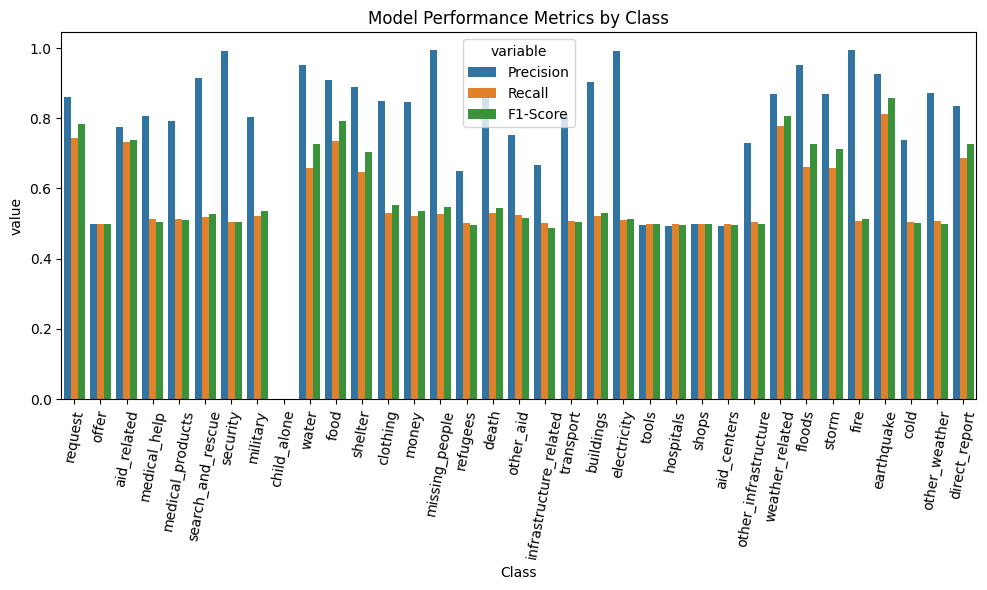

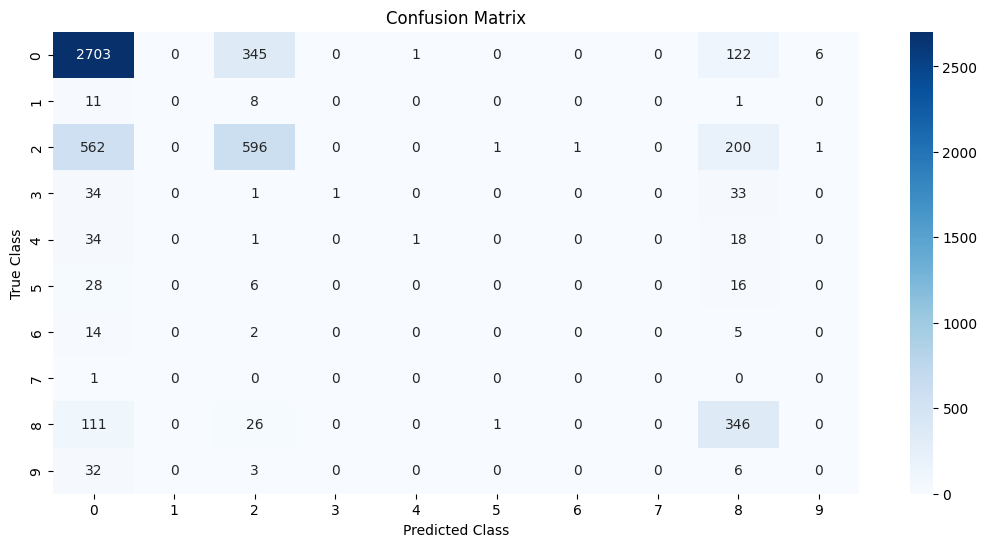

In [967]:
y_pred, metrics_df = evaluate_model(model, X_test, y_test, classes)

### 6. Improve your model
Use grid search to find better parameters. 

In [968]:
# help(sklearn)
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [969]:
def build_model():
    """
    Constructs an ML pipeline for processing text data using a CountVectorizer and 
    TF-IDF transformer, followed by a multi-output classifier with Random Forest.

    The pipeline is designed for multi-label classification and uses GridSearchCV
    to fine-tune hyperparameters, such as n-gram range and Random Forest parameters.

    Returns:
        model (GridSearchCV): A grid search object for training and evaluation, 
        which includes feature extraction, transformation, and a classifier.
    """
    
    text_pipeline = Pipeline([
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer())
    ])
    
     
    model = Pipeline([
        ("features", text_pipeline),
        ("clf", MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # specify parameters for grid search
    parameters = {
        'features__vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 3, 4]
    }
    
    # create grid search object
    cv = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, cv=3, error_score='raise')
    
    return cv

In [970]:
def inspect_pipeline(model, X_train):
    """
    Safely inspect each step of a fitted pipeline.
    
    Args:
        model: Fitted GridSearchCV object
        X_train: Training data to inspect transformations
    """
    if not isinstance(model, GridSearchCV):
        print("Warning: Model is not a GridSearchCV instance")
        return
    
    print("Best Parameters:", model.best_params_)
    print("\nInspecting Pipeline Steps:")
    
    # Access the fitted pipeline
    pipeline = model.best_estimator_
    current_data = X_train
    
    # Iterate through named steps
    for name, transformer in pipeline.named_steps.items():
        print(f"\nStep: {name}")
        print(f"Input shape: {current_data.shape}")
        
        try:
            # Check if step has transform method
            if hasattr(transformer, 'transform'):
                current_data = transformer.transform(current_data)
                print(f"Output shape: {current_data.shape}")
                
                # Print feature names if available
                if hasattr(transformer, 'get_feature_names_out'):
                    features = transformer.get_feature_names_out()
                    print(f"First few features: {features[:5]}")
                    
            else:
                print(f"Note: {name} doesn't have transform method (might be final estimator)")
                
            # Print additional info for specific transformer types
            if hasattr(transformer, 'n_features_in_'):
                print(f"Number of input features: {transformer.n_features_in_}\n")
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}\n")
            continue
    
    return current_data

In [971]:
print(audit_data(X_train, y_train, classes, X_test, y_test))

----------------------------------------------------------------------------------------------------
Dataset Audit Report


,input_features
0,The relief effort to Afghanistan's earthquake ...
1,@trinamariexox I hope Sandy blows open the win...
2,has sanctioned an amount Rs.50.00 crore to dis...


,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,1,1,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


----------------------------------------------------------------------------------------------------

Shapes:
Training set, X: (21108,)
Training set, y: (21108, 35)
Test set, X: (5278,)
Test set, y: (5278, 35)
----------------------------------------------------------------------------------------------------

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------

Target Information:
Unique y values: [ 0  1  2 18 19 20 21 22 27 34]

----------------------------------------------------------------------------------------------------

Class Distribution in Training Set:


,categories,no. of samples
0,request,12821
1,offer,101
2,aid_related,5417
3,medical_help,0
4,medical_products,0
5,search_and_rescue,0
6,security,0
7,military,0
8,child_alone,0
9,water,0


----------------------------------------------------------------------------------------------------


,labels
0,request
1,offer
2,aid_related
3,medical_help
4,medical_products
5,search_and_rescue
6,security
7,military
8,child_alone
9,water




{'train_shapes': {'X_train': (21108,), 'y_train': (21108, 35)}, 'test_shapes': {'X_test': (5278,), 'y_test': (5278, 35)}, 'data_types': {'X_train_type': <class 'numpy.ndarray'>, 'y_train_type': <class 'numpy.ndarray'>}, 'target_info': {'unique_values': array([ 0,  1,  2, 18, 19, 20, 21, 22, 27, 34])}}


In [972]:
new_model = build_model()
new_model.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time= 1.0min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  58.3s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  58.7s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.9min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 2.0min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.9min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.9min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.9min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.9min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 3.6min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 3.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 3.5min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.8min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 7.3min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 7.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 7.3min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  50.6s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  50.1s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  51.7s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.5min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.5min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.5min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 3.1min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 3.2min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 3.1min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.3min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.5min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.4min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 6.2min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 5.9min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 6.2min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  48.3s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  47.9s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  48.5s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.4min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.4min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.5min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.6min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 1); total time= 1.6min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 2.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 2.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=100, features__vect__ngram_range=(1, 2); total time= 2.7min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.0min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.0min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 1); total time= 3.1min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 5.4min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 5.6min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=200, features__vect__ngram_range=(1, 2); total time= 5.5min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('features',
                                        Pipeline(steps=[('vect',
                                                         CountVectorizer(tokenizer=<function tokenize at 0x370b42340>)),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__min_samples_split': [2, 3, 4],
                         'clf__estimator__n_estimators': [50, 100, 200],
                         'features__vect__ngram_range': ((1, 1), (1, 2))},
             verbose=2)

In [973]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(new_model, X_train)

Best Parameters: {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 200, 'features__vect__ngram_range': (1, 2)}

Inspecting Pipeline Steps:

Step: features
Input shape: (21108,)
Output shape: (21108, 226597)
First few features: ['0' '0 0' '0 00' '0 06' '0 1']

Step: clf
Input shape: (21108, 226597)
Note: clf doesn't have transform method (might be final estimator)
Number of input features: 226597



### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

----------------------------------------------------------------------------------------------------
MODEL PERFORMANCE EVALUATION
----------------------------------------------------------------------------------------------------
ML-Pipeline Model
----------------------------------------------------------------------------------------------------
Best parameters found:
{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 200,
 'features__vect__ngram_range': (1, 2)}

Best cross-validation score: 0.4235361000568505
----------------------------------------------------------------------------------------------------
Overall Sample-wise Accuracy: 0.690

----------------------------------------------------------------------------------------------------
                  category  accuracy
0                  request  0.893710
1                    offer  0.996211
2              aid_related  0.781546
3             medical_help  0.924403
4         medical_products  0.95130

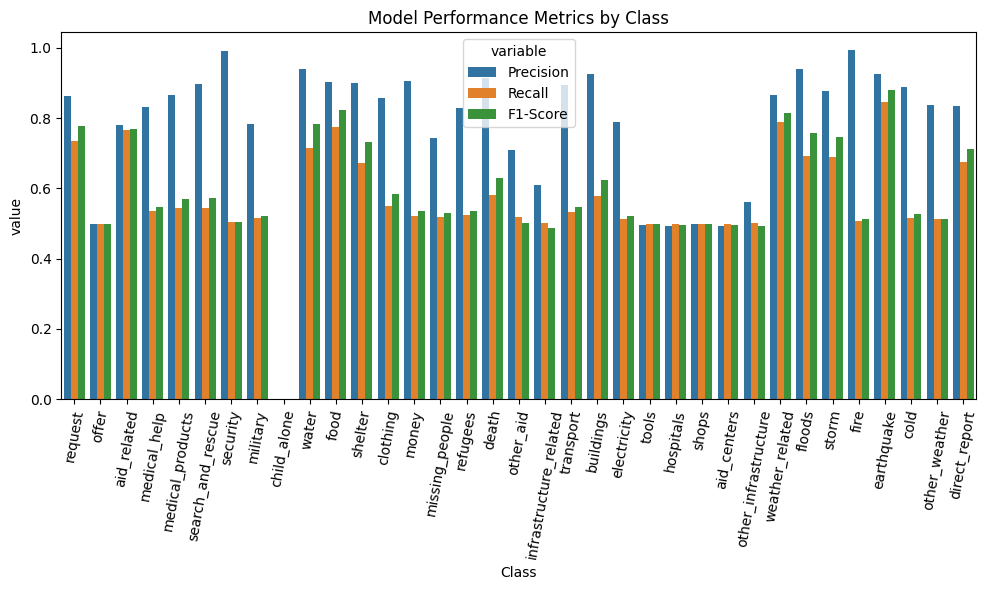

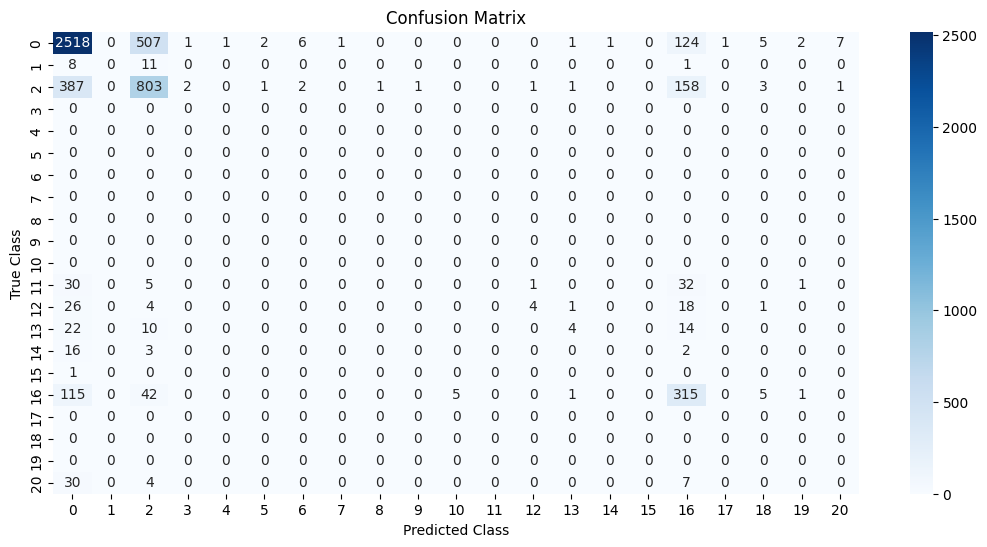

In [974]:
y_pred, metrics_df = evaluate_model(new_model, X_test, y_test, classes)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [975]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        """
        Generates a new binary input feature, (1 if the first word in the input text is a verb, 0 otherwise),
        This feature will be combined with the input text data processed through a TF-IDF transformer pipeline.
        """
        self.run_count = 1
        print("Start Verb Extractor running...")

    def starting_verb(self, text):
        """
        Tags the first word of the tokenized input text.
        
        Args:
            text(string): a row input text message.
        returns:
             tag(integer): 1 if the first word is a verb, 0 otherwise.
        """
        try:
            
            # print("\n\nText:", text)
            sentence_list = nltk.sent_tokenize(text)
            for sentence in sentence_list:
                # Tokenize the sentence
                text_tokens = tokenize(sentence)
                
                if text_tokens:
                    # Get the POS (parts of speech) of the words in the text.
                    first_word, first_tag = nltk.pos_tag(text_tokens)[0]
                    
                    # Check if the first word is a Verb or 'RT' (retweet). 
                    if first_tag in ['VB', 'VBP', 'UH'] or first_word == 'RT':
                        # print("\nVerb, Tag: ",first_tag, ", First Word: ",first_word)
                        tag = 1
                        return tag
                    else:
                        # print(f"\nNon-verb, Tag: {first_tag}, First Word: ,{first_word}")
                        tag = 0
                        return tag
                else:
                    # print(f'Empty Text Tokens, {text_tokens} in "{sentence}"')
                    pass
            
            # If no sentences were found in the entire text.
            self.run_count += 1
            print(f"Non-Text first word({self.run_count}): ", sentence_list)
            print("Default Tag: 0\n")
            tag = 0
            return tag
        
        except IndexError as e:
            print(f"IndexError: {e}")
            print(f"Text causing issue: {text}")
            tag = 0
            return tag
    
        except Exception as e:
            print(f"Unexpected error: {e}")
            print(f"Text causing issue: {text}")
            tag = 0
            return tag
    

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        """
        Transform method.
        
        Args:
            X(numpy.ndarray):input column vector of text messages. Each row is a 
                             sample text message.
        returns:
            df_array(numpy.ndarray):a new column binary vector. Each row is a 
                             1 or 0 (1 if the first word in the corresponding 
                             row in the input column vector is a verb, and 0,
                             otherwise).
        """
        X_tagged = pd.Series(X).apply(self.starting_verb)
        df_array = pd.DataFrame(X_tagged).values # converts to a 2D numpy array.
        # df = X_tagged.values # removing this because the hstack fails.
        
        # Log information about the transformation
        print("\n\nFeature Extraction and Text Transformation Complete:")
        print("Extracted/New feature shape:", df_array.shape)
        print("Input feature shape: ", X.shape)
        
        return df_array

In [976]:
def build_model():
    """
    Constructs an ML pipeline using FeatureUnion to add a new binary feature.
    The feature checks if the first word in each text is a verb (1 if a verb, 0 otherwise),
    and combines this feature with the text data processed through a TF-IDF transformer pipeline.
    The combined feature matrix is used to train the model to enhance its performance.

    Returns:
        model (Pipeline): A scikit-learn pipeline object for training and evaluation, 
        which includes feature extraction, transformation, and a classifier.
    """
    
    text_pipeline = Pipeline([
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer())
    ])
    
    features = FeatureUnion([
        ("text_pipeline",text_pipeline),
        ("starting_verb", StartingVerbExtractor())
    ])
    
    model = Pipeline([
        ("features", features),
        ("clf", MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # specify parameters for grid search
    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 3, 4]
    }
    
    # create grid search object
    cv = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, cv=3, error_score='raise')
    
    return cv

In [977]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# class_weight='balanced'
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [980]:
print(audit_data(X_train, y_train, classes, X_test, y_test))

----------------------------------------------------------------------------------------------------
Dataset Audit Report


,input_features
0,"Jiang Yiman, vice standing president of the RC..."
1,This shipment will contain several tons of med...
2,Hopes of rainfall from a low pressure system c...


,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


----------------------------------------------------------------------------------------------------

Shapes:
Training set, X: (19789,)
Training set, y: (19789, 35)
Test set, X: (6597,)
Test set, y: (6597, 35)
----------------------------------------------------------------------------------------------------

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------

Target Information:
Unique y values: [ 0  1  2 18 19 20 21 22 27 34]

----------------------------------------------------------------------------------------------------

Class Distribution in Training Set:


,categories,no. of samples
0,request,11897
1,offer,87
2,aid_related,5144
3,medical_help,0
4,medical_products,0
5,search_and_rescue,0
6,security,0
7,military,0
8,child_alone,0
9,water,0


----------------------------------------------------------------------------------------------------


,labels
0,request
1,offer
2,aid_related
3,medical_help
4,medical_products
5,search_and_rescue
6,security
7,military
8,child_alone
9,water




{'train_shapes': {'X_train': (19789,), 'y_train': (19789, 35)}, 'test_shapes': {'X_test': (6597,), 'y_test': (6597, 35)}, 'data_types': {'X_train_type': <class 'numpy.ndarray'>, 'y_train_type': <class 'numpy.ndarray'>}, 'target_info': {'unique_values': array([ 0,  1,  2, 18, 19, 20, 21, 22, 27, 34])}}


In [981]:
new_model = build_model()
new_model.fit(X_train, y_train)

Start Verb Extractor running...
Start Verb Extractor running...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Start Verb Extractor running...


ValueError: Invalid parameter 'vect' for estimator FeatureUnion(transformer_list=[('text_pipeline',
                                Pipeline(steps=[('vect',
                                                 CountVectorizer(tokenizer=<function tokenize at 0x370b42340>)),
                                                ('tfidf',
                                                 TfidfTransformer())])),
                               ('starting_verb', StartingVerbExtractor())]). Valid parameters are: ['n_jobs', 'transformer_list', 'transformer_weights', 'verbose', 'verbose_feature_names_out'].

In [345]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(new_model, X_train)

Best Parameters: {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 50, 'features__text_pipeline__vect__ngram_range': (1, 2)}

Inspecting Pipeline Steps:

Step: features
Input shape: (19789,)
Empty Text (6):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0
Empty Text (7):  []
Default Tag: 0
Empty Text (8):  []
Default Tag: 0
Empty Text (9):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (19789, 1)
Input feature shape:  (19789,)
Output shape: (19789, 214668)
Error processing features: Transformer starting_verb (type StartingVerbExtractor) does not provide get_feature_names_out.


Step: clf
Input shape: (19789, 214668)
Note: clf doesn't have transform method (might be final estimator)
Number of input features: 214668



----------------------------------------------------------------------------------------------------
MODEL PERFORMANCE EVALUATION
----------------------------------------------------------------------------------------------------
Empty Text (10):  ['          .']
Default Tag: 0
Empty Text (11):  ['//// // @:@']
Default Tag: 0


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
Best parameters found:
{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 50,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

Best cross-validation score: 0.40754973769401465
----------------------------------------------------------------------------------------------------
Overall Sample-wise Accuracy: 0.693

----------------------------------------------------------------------------------------------------
                  category  accuracy
0                  request  0.893740
1                    offer  

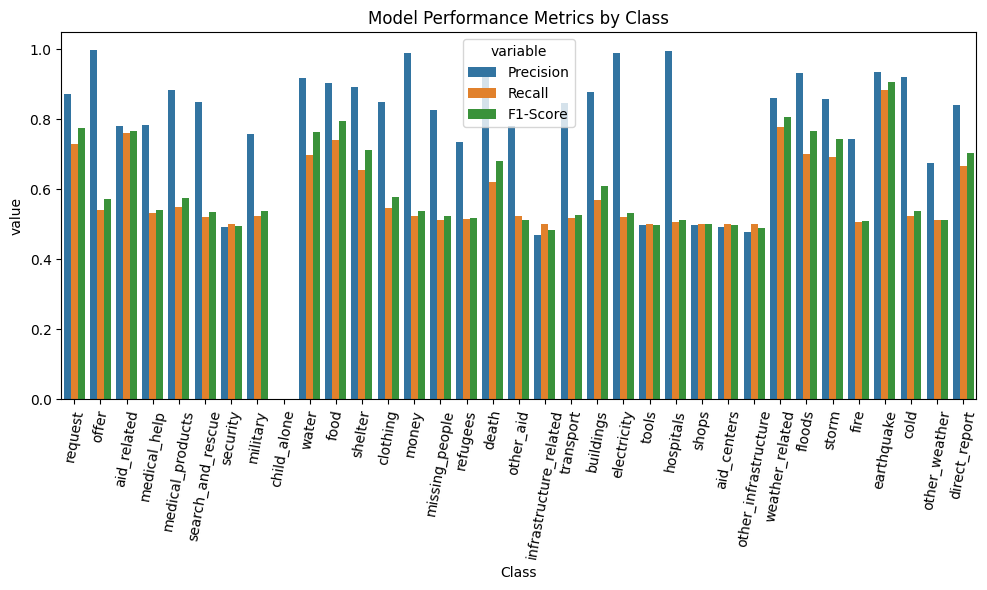

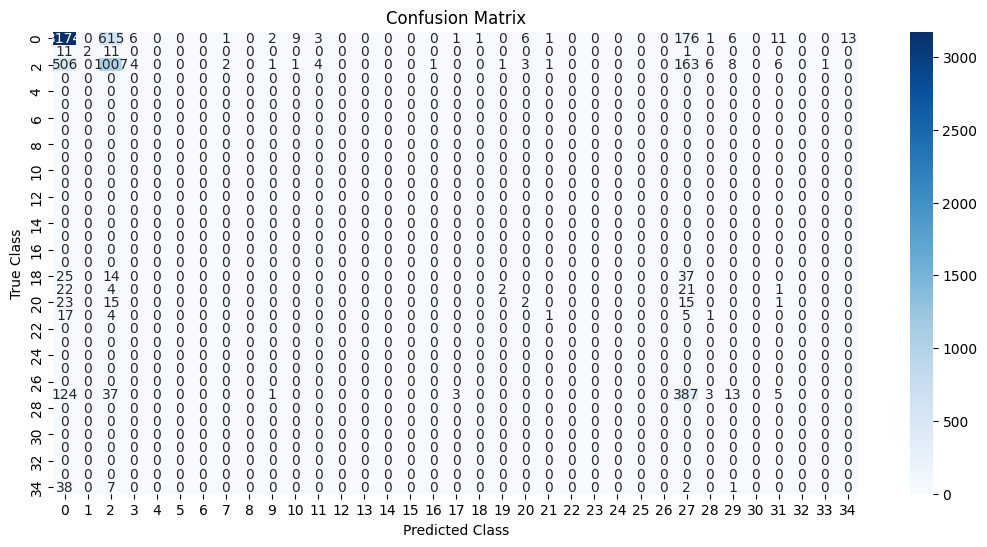

----------------------------------------------------------------------------------------------------

Class Distribution in Test Set:
----------------------------------------------------------------------------------------------------
request: 4026 samples
offer: 25 samples
aid_related: 1715 samples
infrastructure_related: 76 samples
transport: 50 samples
buildings: 56 samples
electricity: 28 samples
weather_related: 573 samples
direct_report: 48 samples




In [346]:
y_pred, metrics_df = evaluate_model(new_model, X_test, y_test, classes)

### 9. Export your model as a pickle file

In [ ]:
import pickle 

In [347]:
def save_model(model, filepath='train_classifier.pkl'):
    """
    Saves the ML model as a pickle file.

    Args:
        model (pipeline or GridSearchCV object): The ML model to be saved.
        filepath (str): Specified filename and path to save the ML model.
    """
    try:
        # Export the model using pickle
        with open(filepath, 'wb') as model_file:
            pickle.dump(model, model_file)

        print("Model exported successfully!")
    except Exception as e:
        print(f"Error saving model: {e}")

In [ ]:
save_model(new_model)

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [357]:
def main():
    """
    ML model run script.
    """
    # load data from database
    db_path = 'DisasterTweets.db'
    X, y, classes = load_data(
                            x_column_name="message",
                            y_start=5,
                            table_name="cleandata",
                            database_path=db_path
                        )
                                        
    # Inspect the training dataset
    print(audit_data(X, y, classes))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
    
    # Inspect the split training and test dataset   
    print(audit_data(X_train, y_train, classes, X_test, y_test))
    
    model = build_model()
    model.fit(X_train, y_train)
    
    # ensure the outputs of each transformer is of the shape we expect.
    output_data = inspect_pipeline(model, X_train)
    
    y_pred, metrics_df = evaluate_model(model, X_test, y_test, classes) 

In [358]:
main()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
Name: message, dtype: object


labels: ['request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']

----------------------------------------------------------------------------------------------------
Dataset Audit Report
----------------------------------------------------------------------------------------------------

Shapes:
Training set, X: (26386,)
Training set, y: (26386, 35)
----------------------------------------------------------------------------------------------------

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
-----------------------------------------

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0

Non-Text first word(3):  []
Default Tag: 0

Non-Text first word(4):  ['          .']
Default Tag: 0

Non-Text first word(5):  ['//// // @:@']
Default Tag: 0

Non-Text first word(6):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  20.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['          .']
Default Tag: 0

Non-Text first word(3):  ['//// // @:@']
Default Tag: 0

Non-Text first word(4):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Non-Text first word(5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0

Non-Text first word(6):  []
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  20.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0

Non-Text first word(3):  []
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Non-Text first word(4):  ['          .']
Default Tag: 0

Non-Text first word(5):  ['//// // @:@']
Default Tag: 0

Non-Text first word(6):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  22.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0

Non-Text first word(3):  []
Default Tag: 0

Non-Text first word(4):  ['          .']
Default Tag: 0

Non-Text first word(5):  ['//// // @:@']
Default Tag: 0

Non-Text first word(6):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  31.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['          .']
Default Tag: 0

Non-Text first word(3):  ['//// // @:@']
Default Tag: 0

Non-Text first word(4):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Non-Text first word(5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0

Non-Text first word(6):  []
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  32.4s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0

Non-Text first word(3):  []
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Non-Text first word(4):  ['          .']
Default Tag: 0

Non-Text first word(5):  ['//// // @:@']
Default Tag: 0

Non-Text first word(6):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  35.0s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Default Tag: 0

Non-Text first word(3):  []
Default Tag: 0

Non-Text first word(4):  ['          .']
Default Tag: 0

Non-Text first word(5):  ['//// // @:@']
Default Tag: 0

Non-Text first word(6):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  39.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Non-Text first word(2):  ['          .']
Default Tag: 0

Non-Text first word(3):  ['//// // @:@']
Default Tag: 0

Non-Text first word(4):  ['http://wap.sina.comhttp://wap.sina.com']
Default Tag: 0



Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


KeyboardInterrupt: 